# Generalization for $\mathbb{R}^n$

Our framework should automatically recognize objective funcion domain and use proper routines for each domain ($\mathbb{Z}^n$ or $\mathbb{R}^n$).

### Set up IPython notebook environment first...

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np

## Testing `numpy.dtype`

In [3]:
zn = np.ones(10, dtype=int)
zn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [4]:
zn.dtype

dtype('int64')

In [5]:
rn = np.ones(10)
rn

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
rn.dtype

dtype('float64')

In [7]:
from heur_aux import is_integer

In [8]:
is_integer(rn)

False

In [9]:
is_integer(zn)

True

## De Jong 1 objective function

Source: http://www.geatbx.com/docu/fcnindex-01.html#P89_3085

In [10]:
from objfun_dejong1 import DeJong1  # substatial difference to existing functions is the epsilon parameter!

In [11]:
dj = DeJong1(n=3, eps=0.1)

In [12]:
dj.a

array([-5.12, -5.12, -5.12])

In [13]:
dj.b

array([5.12, 5.12, 5.12])

In [14]:
x = dj.generate_point()
x

array([-4.84984986, -2.53825221, -3.33395388])

In [15]:
dj.evaluate(x)

41.079016439703125

In [16]:
# optimum
dj.evaluate(np.zeros(5))

0.0

## Generalized mutation demo on De Jong 1

Let's test mutation corrections first:

In [17]:
from heur_aux import Correction, MirrorCorrection, ExtensionCorrection

In [18]:
# sticky correction in R^n (mind x[1])
Correction(dj).correct(np.array([6.12, -4.38,  2.96]))

array([ 5.12, -4.38,  2.96])

In [19]:
# mirror correction in R^n (mind x[1])
MirrorCorrection(dj).correct(np.array([6.12, -4.38,  2.96]))

array([ 4.12, -4.38,  2.96])

In [20]:
# extension correction in R^n (mind x[1])
ExtensionCorrection(dj).correct(np.array([6.12, -4.38,  2.96]))

array([-4.12, -4.38,  2.96])

I.e. corrections work also in the continuous case, as expected...

In [21]:
from heur_aux import CauchyMutation

In [22]:
cauchy = CauchyMutation(r=.1, correction=MirrorCorrection(dj))
cauchy.mutate(np.array([6.12, -4.38,  2.96]))

array([ 4.10025476, -4.55598625,  2.9011142 ])

## De Jong 1 optimization via FSA

Thanks to current state of the framework, no modification to FSA is needed.

In [23]:
from heur_fsa import FastSimulatedAnnealing

In [24]:
heur = FastSimulatedAnnealing(dj, maxeval=10000, T0=10, n0=10, alpha=2, 
                              mutation=cauchy)
res = heur.search()
print(res['best_x'])
print(res['best_y'])
print(res['neval'])

[-0.18044515 -0.07083298 -0.01462748]
0.03779172776631849
93


## De Jong 1 optimization via GO

Let's review modified crossover operators in $\mathbb{R}^n$ first:

In [25]:
from heur_go import Crossover, UniformMultipoint, RandomCombination

In [26]:
x = dj.generate_point()
y = dj.generate_point()
print(x)
print(y)

[ 2.46988903 -2.69484687 -3.48620522]
[ 4.35504478  4.39930577 -2.15476121]


In [27]:
Crossover().crossover(x, y)

array([ 2.46988903, -2.69484687, -2.15476121])

In [28]:
UniformMultipoint(1).crossover(x, y)

array([ 2.46988903, -2.69484687, -2.15476121])

In [29]:
RandomCombination().crossover(x, y)

array([ 2.80742653,  3.62555241, -2.64362892])

They work as expected.

Finally, let's run GO:

In [30]:
from heur_go import GeneticOptimization

In [31]:
heur = GeneticOptimization(dj, maxeval=10000, N=10, M=30, Tsel1=0.5, Tsel2=0.1, 
                           mutation=cauchy, crossover=UniformMultipoint(1))
res = heur.search()
print(res['best_x'])
print(res['best_y'])
print(res['neval'])

[0.01321063 0.05447072 0.08992001]
0.011227187184402668
30


# _h_-means

Heuristic cluster analysis inspired by [_k_-means](https://en.wikipedia.org/wiki/K-means_clustering). Another demonstration of how continuous heuristics can be used — example of an application.

In [32]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [33]:
from objfun_hmeans import HMeans

In [34]:
of = HMeans()  

In [35]:
print('f* = {}'.format(of.fstar))

f* = 0.3084489218103048


<IPython.core.display.Javascript object>


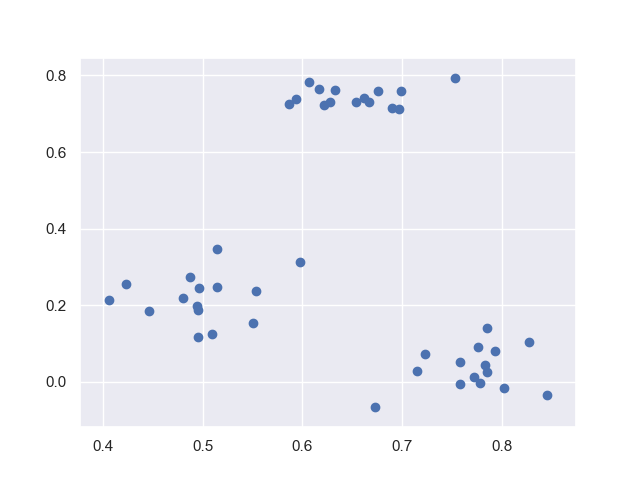

In [36]:
# plot the data points
X = of.X
ax = plt.scatter(x=X[:, 0], y=X[:, 1]);

In [37]:
print('a = {}'.format(of.a))
print('b = {}'.format(of.b))

a = [ 0.40569774 -0.06641667  0.40569774 -0.06641667  0.40569774 -0.06641667]
b = [0.84554749 0.79467683 0.84554749 0.79467683 0.84554749 0.79467683]


**Bounds are repeated for each centroid, that will be tuned by the heuristic.**

In [38]:
# some random evaluations
for i in range(10):
    x = of.generate_point()
    print('f({}) = {}'.format(x, of.evaluate(x)))

f([0.78194912 0.71860281 0.58602198 0.03709441 0.35065639 0.56319068]) = 1.5757117098259972
f([0.29972987 0.51233415 0.67346693 0.15919373 0.05047767 0.33781589]) = 3.771019226633744
f([0.10806377 0.17890281 0.8858271  0.36536497 0.21876935 0.75249617]) = 6.4964980944298425
f([0.10687958 0.74460324 0.46978529 0.59825567 0.14762019 0.18403482]) = 8.436064778545106
f([0.64507213 0.04862801 0.24861251 0.54240852 0.22677334 0.38141153]) = 4.187560378845203
f([0.92223279 0.92535687 0.56674992 0.53347088 0.01486002 0.97789926]) = 6.812173194286739
f([0.5730289  0.791757   0.56155736 0.87733524 0.58419583 0.70884983]) = 11.294668250484552
f([0.14853345 0.42845074 0.69389007 0.10461974 0.43960524 0.16620215]) = 5.716204583147944
f([0.50697863 0.81903586 0.09010673 0.80006875 0.56512635 0.58934771]) = 7.915603507292262
f([0.19810066 0.43611826 0.29590376 0.03755768 0.03068484 0.453105  ]) = 9.194794833445604


In [39]:
# we can get cluster labels (for a random solution)
labels = of.get_cluster_labels(x)
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1]


In [40]:
# auxiliary routine
def visualize_solution(x, of):
    labels = of.get_cluster_labels(x)
    X = of.X
    ax = plt.scatter(x=X[:, 0], y=X[:, 1], c=labels)

<IPython.core.display.Javascript object>


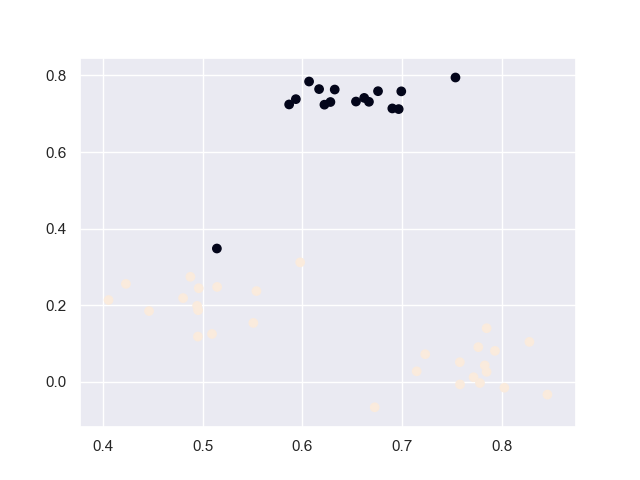

In [41]:
# visualization of a random solution
visualize_solution(x, of);

## Optimization demonstration

In [42]:
from heur_aux import MirrorCorrection, CauchyMutation
from heur_fsa import FastSimulatedAnnealing

In [43]:
heur = FastSimulatedAnnealing(of, maxeval=10000, T0=10, n0=10, alpha=2, 
                              mutation=CauchyMutation(r=0.1, correction=MirrorCorrection(of)))
res = heur.search()
print('x_best = {}'.format(res['best_x']))
print('y_best = {}'.format(res['best_y']))
print('neval = {}'.format(res['neval']))

x_best = [0.74645552 0.0499427  0.46357474 0.16920205 0.67805373 0.71820457]
y_best = 0.29138104832060957
neval = 304


<IPython.core.display.Javascript object>


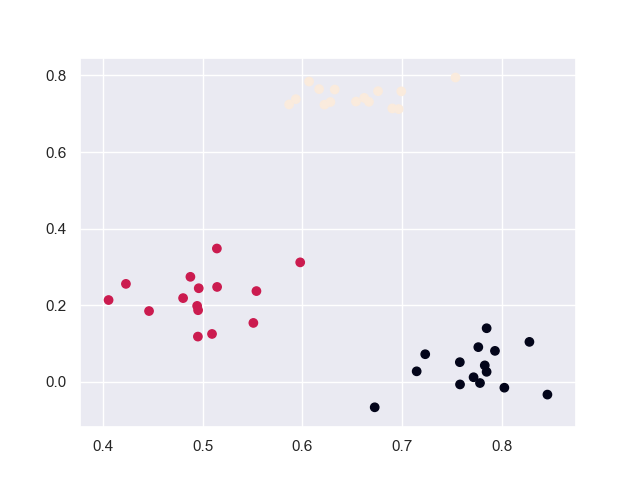

In [44]:
visualize_solution(res['best_x'], of)

# Assignments

* Re. _h_-means
  * Improve the implementation of this objective function (especially the random solution generator)
  * Tune heuristics for this objective function
  * Tune this objective function, e.g. by penalization for smaller number of clusters than $h$ (and make sure you understand why this is possible)
  * Compare heuristic approach to the original _k_-means
* Tune heuristics on other continuous [benchmark functions](http://www.geatbx.com/docu/fcnindex-01.html)